In [43]:
print("Hello World")

Hello World


In [44]:
import numpy as np
import matplotlib.pyplot as plt   
from atasi import AtasiNet     

In [45]:

fc = 14.25e9 #Hz
lambda_c = 0.021 #m
delta_D = 0.084 #m
R0 = 400 #m
theta = 45*np.pi/180 #rad
n_antennas = 8 #number of antennas
n_samples = 1000 #number of samples
n_grids = 128 #number of grids

In [46]:
def generate_backscatter_coefficients(num_samples):
    A = np.random.rayleigh(scale=2, size=num_samples)  # Scale parameter adjusted for 0 to 4 range
    phi = np.random.uniform(0, 2 * np.pi, size=num_samples)
    gamma = A * np.exp(1j * phi)
    return gamma

#referred to as A in the model implementation part
def compute_baseline_lengths(n, delta_d, theta):
    return np.array([k * delta_d * np.sin(theta) for k in range(n)])

def compute_measurement_matrix(baselines, num_grids, wavelength, R0):
    s = np.linspace(-1, 1, num_grids)  # Assuming s is normalized between -1 and 1
    D = np.exp(1j * 4 * np.pi * np.outer(baselines, s) / (wavelength * R0))
    return D

def simulate_backscattered_signal(gamma, D):
    return np.dot(D, gamma)

(8, 128)


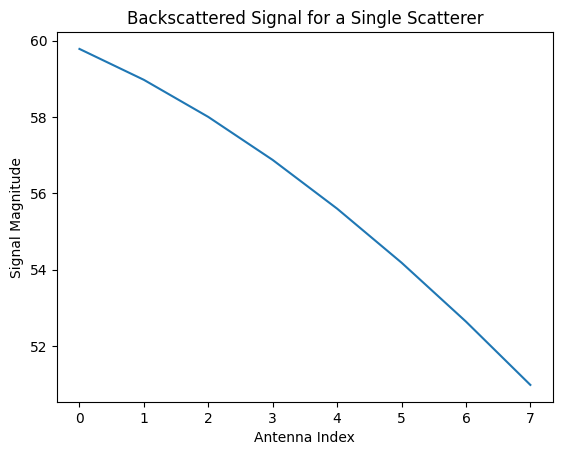

In [47]:
baselines = compute_baseline_lengths(n_antennas, delta_D, theta)
D = compute_measurement_matrix(baselines, n_grids, lambda_c, R0)
print(D.shape)

signals_single = np.zeros((n_samples, n_antennas), dtype=complex)

for i in range(n_samples):
    gamma_single = generate_backscatter_coefficients(n_grids)
    signals_single[i, :] = simulate_backscattered_signal(gamma_single, D)

plt.plot(np.abs(signals_single[0, :]))
plt.xlabel('Antenna Index')
plt.ylabel('Signal Magnitude')
plt.title('Backscattered Signal for a Single Scatterer')
plt.show()

In [48]:
# Example usage
A = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
model = AtasiNet(A)
W = model.compute_w()
print(W)
print(A)
score = np.linalg.norm(W.T@A)**2
print(score)


[[1.00000000e+00 1.06407496e-05 1.00290600e-05]
 [1.71511331e-05 1.00000000e+00 1.91614559e-06]
 [1.20663140e-05 3.68936165e-06 1.00000000e+00]]
[[1 0 0]
 [0 1 0]
 [0 0 1]]
3.0000000006708483
